# Exemplo 13: Reconhecimento de Imagens e Augmentação usando Tensorflow e Keras

## Exemplo reconhecimento de espécies de flores

Um dos problemas clássicos de Aprendizado Profundo (Deep Learning) usando Redes Neurais Convolucionais (CNNs) é a identificação de flores. A partir de uma base com 4500 imagens JPEG de 5 espécies de flores com cores, tamanhos e ângulos diferentes podemos identificar a qual espécie uma foto de flor qualquer pode ser classificada.   

Este exemplo mostra uma forma usual de organização de classificação de imagens. As imagens já classificadas são colocadas em diretórios diferentes com o nome da espécie. O programa inicialmente lê um diretório de imagens, cria um vetor de features e inclui um tag de identificação igual ao nome do diretório. Cada diretório pode comnter qualquer numero de imagens, no entanto, é obrigatório que cada diretório possua apenas uma categoria de imagem.

Aumento de dados (em inglês, augmentation) é uma técnica usada para expandir ou ampliar o conjunto de dados para treinamento do modelo usando variações dos dados existentes. Para isso, aplicamos diferentes técnicas para expandir nosso conjunto de dados de modo que ajude a treinar melhor nosso modelo com um conjunto de dados maior. O aumento de imagem (image augmentation) é uma das técnicas que podemos aplicar em um conjunto de dados de imagem para expandir nosso conjunto de dados de forma que reduza o overfitting em nosso modelo. As técnicas mais comuns são deslocar a imagem, espelhar horizontal e verticalmente, aplicar zoom e variar contraste. Essa técnica deve ser usada com cuidado, pois seu uso pode piorar a acurácia além de aumentar o tempo de processamento.

A base de dados é separada em base de treinamento e base de validação (teste). A rede é treinada com a base de treinamento e a base de validação avalia a acurácia de cada modelo utilizado e o tempo de treinamento é medido.

O primeiro modelo é o simples, com poucas camadas. O segundo é o modelo complexo com 18 camadas. Depois usaremos redes pré-treinadas. A técnica chamada aprendizagem de transferência, onde uma rede pré-treinada (treinada com cerca de um milhão de imagens genericas), é usada para extrair atributos e treinar uma nova camada no topo para classificar as imagens de flores.

No final é apresentado uma tabela comparando a acurácia e tempo de processamento do treinamento de cada modelo.

In [1]:
# Load libs
import os, pathlib, logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
from time import perf_counter

import tensorflow as tf
from tensorflow.keras import layers, models, utils
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import IPython.display as display
import numpy as np
import matplotlib.pyplot as plt

AUTOTUNE = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.OneDeviceStrategy(device="/GPU:0")

print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
from tensorflow.python.platform import build_info as build
print(f"Cuda Version: {build.build_info['cuda_version']}")
print(f"Cudnn version: {build.build_info['cudnn_version']}")

TF version: 2.16.1
GPU is available
Cuda Version: 12.3
Cudnn version: 8


## Set hyperparameters

In [2]:
# Set hyperparameters
VAL_SAMPLE = 0.2
BATCH_SIZE = 50
SHUFFLE_BUFFER = 1000
IMG_HEIGHT = 224
IMG_WIDTH = 224
EPOCHS=5

# Set main images directory
data_repo = "/data/dataset/flower_photos/"

# Set base directory (where are all flower's directories)
data_dir = pathlib.Path(data_repo)
print(data_dir)

data/flower/train


## Bibliotecas úteis

In [3]:
# Print some flowers
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(20):
        ax = plt.subplot(5,5,n+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')
    plt.show()

## Leitura images do repositorio

In [4]:
# Estrutura dos diretorios
#
# data_repo / dandelion  / image_x.jpg ... 
#           / daisy      / image_x.jpg ...
#           / sunflower  / image_x.jpg ...
#           / rose       / image_x.jpg ...
#           / tulip      / image_x.jpg ...

# Count the number of flower images and set dataset size
SIZE_OF_DATASET = len(list(data_dir.glob('*/*.jpg')))

print("Number of images: ",SIZE_OF_DATASET)

Number of images:  2746


In [5]:
# Get the Class names reading directory names
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
print(CLASS_NAMES)

['tulip' 'dandelion' 'sunflower' 'daisy' 'rose']


## Image Processing and Augmentation

In [6]:
#Set start time for prepare images
start_time = perf_counter()

# Configuring Image generator to execute image augmentation in training data
train_datagen = ImageDataGenerator(
    validation_split=VAL_SAMPLE,    # Split validation data
    rescale=1./255,                  # scale images from integers 0-255 to floats 0-1.
#    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#    horizontal_flip=True 
)

# Configuring Image generator to rescale image in validation data (they dont need augmentation)
val_datagen = ImageDataGenerator(
    validation_split=VAL_SAMPLE,  # Split validation data
    rescale=1./255,                # scale images from integers 0-255 to floats 0-1.
)

In [7]:
# Create augmented training dataset reading images from directory
train_ds = train_datagen.flow_from_directory(
    data_dir,                            # directory name in format class/images.jpg
    class_mode='categorical',            # classe type
    color_mode='rgb',                    # 'grayscale', 'rgb', 'rgba' 
    subset="training",                   # define train dataset
    seed=123,
    target_size=(IMG_HEIGHT, IMG_WIDTH), # output image size
    classes = list(CLASS_NAMES),         # list of classes names
    shuffle=True,                        # Set shuffle
    batch_size=BATCH_SIZE                # Batch size
)

Found 2198 images belonging to 5 classes.


In [8]:
# Create validation dataset reading images from directory
val_ds = val_datagen.flow_from_directory(
    data_dir,                            # directory name in format class/images.jpg
    class_mode='categorical',            # classe type
    color_mode='rgb',                    # 'grayscale', 'rgb', 'rgba' 
    subset="validation",                 # define validation dataset
    seed=123,
    target_size=(IMG_HEIGHT, IMG_WIDTH), # output image size
    classes = list(CLASS_NAMES),         # list of classes names
    shuffle=True,                        # Set shuffle
    batch_size=BATCH_SIZE                # Batch size
)

Found 548 images belonging to 5 classes.


In [9]:
# Calculate train and validation step
#STEP_SIZE_TRAIN=train_ds.n//train_ds.batch_size
#STEP_SIZE_VALID=val_ds.n//val_ds.batch_size

In [10]:
time_ip = perf_counter() - start_time
tf.print("Image processing time: ", time_ip, "s")

Image processing time:  0.1726708839996718 s


(50, 224, 224, 3) (50, 5)


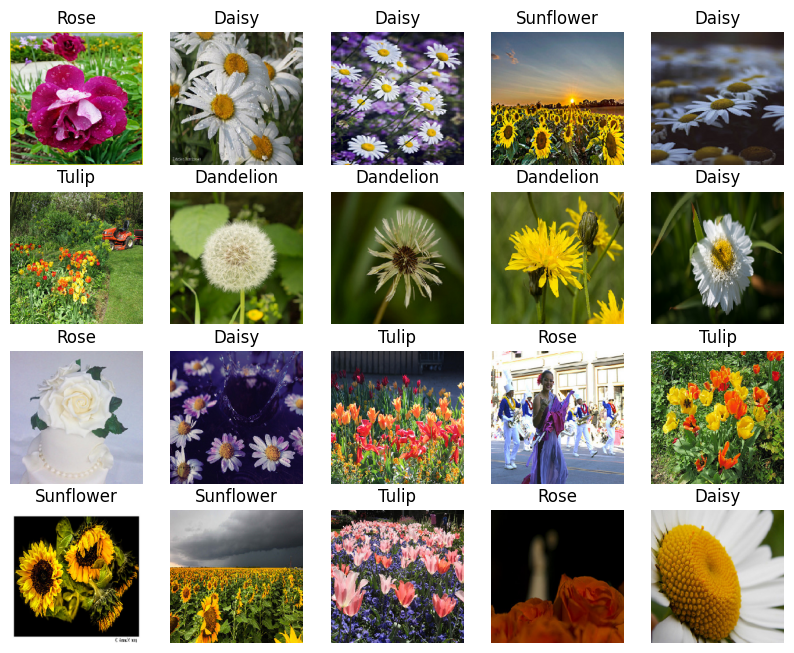

In [11]:
# Print some images with label
images, labels = next(val_ds)
print(images.shape, labels.shape)
show_batch(images, labels)

# Create Convolutional Neural Network (CNN) Model

## Simple Model

In [12]:
start_time = perf_counter()

model = models.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(5, activation='relu'),
    layers.Dense(5)
], name = 'Simple_Model')

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "Simple_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │       250,885 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            30 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 274,499 (1.05 MB)

 Trainable params: 274,499 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1718237235.768942  752829 service.cc:145] XLA service 0x7f0678105c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718237235.768991  752829 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9


 1/44 ━━━━━━━━━━━━━━━━━━━━ 6:26 9s/step - accuracy: 0.1800 - loss: 1.6107

I0000 00:00:1718237238.599378  752829 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/44 ━━━━━━━━━━━━━━━━━━━━ 33s 558ms/step - accuracy: 0.2206 - loss: 1.5942 - val_accuracy: 0.2281 - val_loss: 1.5621
Epoch 2/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 508ms/step - accuracy: 0.2319 - loss: 1.5350 - val_accuracy: 0.3613 - val_loss: 1.4960
Epoch 3/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 504ms/step - accuracy: 0.3487 - loss: 1.4876 - val_accuracy: 0.3613 - val_loss: 1.4863
Epoch 4/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 514ms/step - accuracy: 0.3477 - loss: 1.4501 - val_accuracy: 0.3741 - val_loss: 1.4347
Epoch 5/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 509ms/step - accuracy: 0.3567 - loss: 1.4497 - val_accuracy: 0.3431 - val_loss: 1.4688


### Evaluating the Simple CNN Model Performance

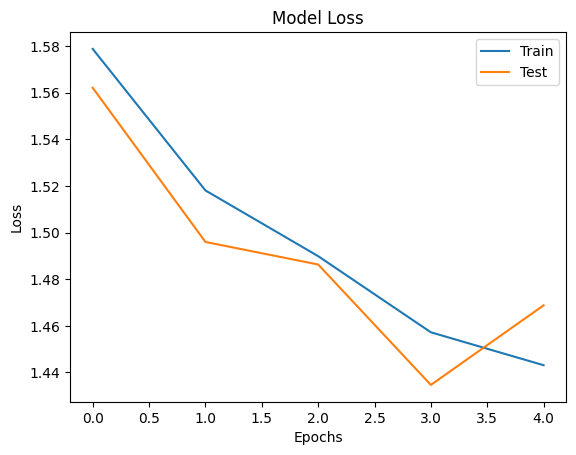

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

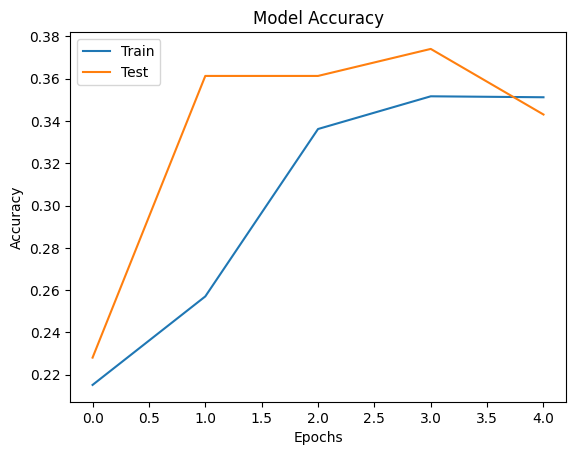

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [16]:
train_loss_sm, train_acc_sm = model.evaluate(train_ds, batch_size=BATCH_SIZE)
test_loss_sm, test_acc_sm = model.evaluate(val_ds, batch_size=BATCH_SIZE)
time_sm = perf_counter() - start_time
print(time_sm)

44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 562ms/step - accuracy: 0.3574 - loss: 1.4255
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.3351 - loss: 1.4631
169.222196024999


## Complex Model 

In [17]:
start_time = perf_counter()

model = models.Sequential([
# layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    layers.Conv2D(32, (3,3), padding='same', activation='relu', name='conv_1'),
    layers.Conv2D(32, (3,3), activation='relu', name='conv_2'),
    layers.MaxPooling2D(pool_size=(2,2), name='maxpool_1'),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3,3), padding='same', activation='relu', name='conv_3'),
    layers.Conv2D(64, (3,3), activation='relu', name='conv_4'),
    layers.MaxPooling2D(pool_size=(2,2), name='maxpool_2'),
    layers.Dropout(0.25),
    layers.Conv2D(128, (3,3), padding='same', activation='relu', name='conv_5'),
    layers.Conv2D(128, (3,3), activation='relu', name='conv_6'),
    layers.MaxPooling2D(pool_size=(2,2), name='maxpool_3'),
    layers.Flatten(),
    layers.Dense(512, activation='relu', name='dense_1'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', name='dense_2'),
    layers.Dense(len(CLASS_NAMES), name='output'),
    layers.Activation('softmax')
], name = 'Complex_Model')

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "Complex_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 222, 222, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 111, 111, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 109, 109, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling2D)        │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5 (Conv2D)                 │ (None, 54, 54, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_6 (Conv2D)                 │ (None, 52, 52, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_3 (MaxPooling2D)        │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │           645 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,656,165 (170.35 MB)

 Trainable params: 44,656,165 (170.35 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/5
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 829ms/step - accuracy: 0.2173 - loss: 1.7596

I0000 00:00:1718237455.893384  759906 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_101', 4 bytes spill stores, 4 bytes spill loads



44/44 ━━━━━━━━━━━━━━━━━━━━ 61s 948ms/step - accuracy: 0.2180 - loss: 1.7546 - val_accuracy: 0.2737 - val_loss: 1.5819
Epoch 2/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 515ms/step - accuracy: 0.3102 - loss: 1.5299 - val_accuracy: 0.3431 - val_loss: 1.4468
Epoch 3/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 30s 582ms/step - accuracy: 0.3628 - loss: 1.4171 - val_accuracy: 0.3777 - val_loss: 1.3838
Epoch 4/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 511ms/step - accuracy: 0.4130 - loss: 1.3668 - val_accuracy: 0.4453 - val_loss: 1.3378
Epoch 5/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 511ms/step - accuracy: 0.4558 - loss: 1.3184 - val_accuracy: 0.4690 - val_loss: 1.3166


### Evaluating the Complex CNN Model Performance

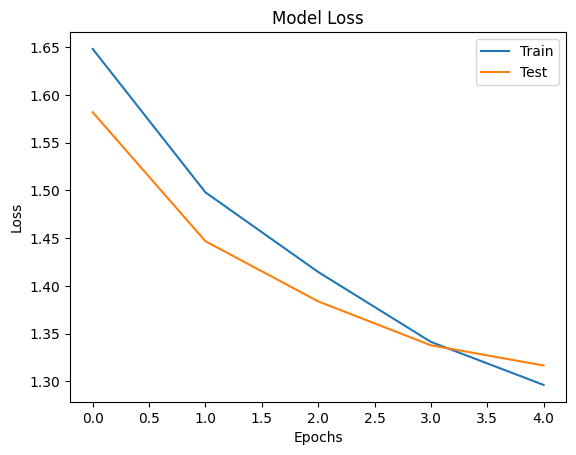

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

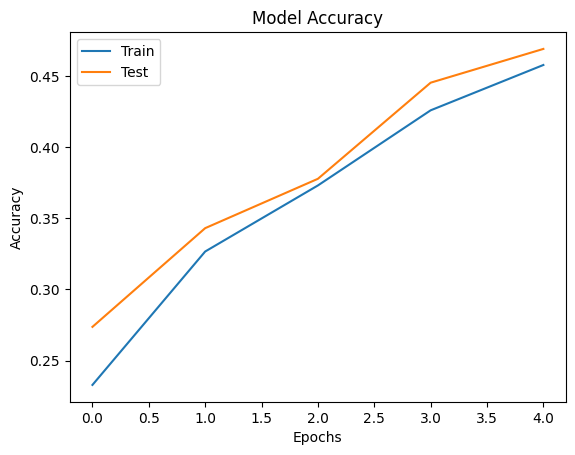

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [21]:
train_loss_cm, train_acc_cm = model.evaluate(train_ds, batch_size=BATCH_SIZE)
test_loss_cm, test_acc_cm = model.evaluate(val_ds, batch_size=BATCH_SIZE)
time_cm = perf_counter() - start_time
print(time_cm)

44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 638ms/step - accuracy: 0.4513 - loss: 1.2224
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.4855 - loss: 1.2825
205.45545591799964


## Transfer Learning: VGG19 Pre-trained Model

In [22]:
start_time = perf_counter()

pre_trained_model = VGG19(input_shape=(IMG_HEIGHT, IMG_WIDTH ,3), include_top=False, weights="imagenet")

#pre_trained_model.trainable = False
for layer in pre_trained_model.layers[:19]:
    layer.trainable = False

# creating the final model  
model = models.Sequential([
    pre_trained_model,
    layers.MaxPool2D((2,2) , strides = 2),
    layers.Flatten(),
    layers.Dense(len(CLASS_NAMES) , activation='softmax')
], name = 'VGG19_Model')

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "VGG19_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ ?                      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 4,719,616 (18.00 MB)

 Non-trainable params: 15,304,768 (58.38 MB)

In [23]:
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


44/44 ━━━━━━━━━━━━━━━━━━━━ 43s 679ms/step - accuracy: 0.5231 - loss: 1.2547 - val_accuracy: 0.7628 - val_loss: 0.6332
Epoch 2/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 514ms/step - accuracy: 0.8239 - loss: 0.5087 - val_accuracy: 0.7901 - val_loss: 0.5239
Epoch 3/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 514ms/step - accuracy: 0.8394 - loss: 0.4124 - val_accuracy: 0.8157 - val_loss: 0.5519
Epoch 4/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 512ms/step - accuracy: 0.8918 - loss: 0.2829 - val_accuracy: 0.8467 - val_loss: 0.4464
Epoch 5/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 513ms/step - accuracy: 0.9301 - loss: 0.1878 - val_accuracy: 0.8504 - val_loss: 0.4806


### Evaluating the VGG19 CNN Model Performance

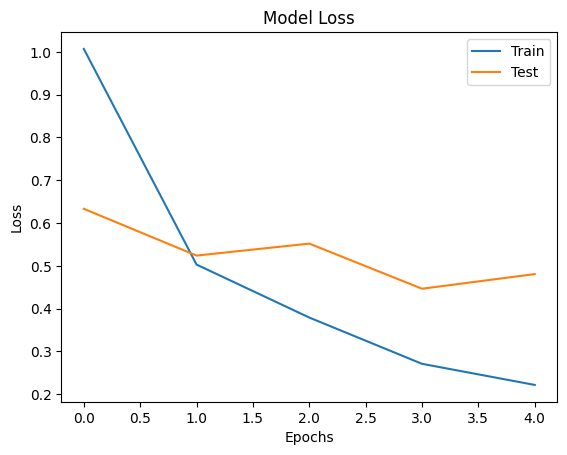

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

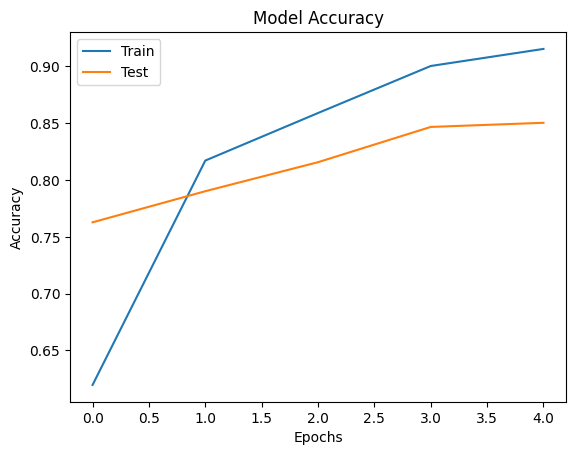

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [26]:
train_loss_vg, train_acc_vg = model.evaluate(train_ds, batch_size=BATCH_SIZE)
test_loss_vg, test_acc_vg = model.evaluate(val_ds, batch_size=BATCH_SIZE)
time_vg = perf_counter() - start_time
print(time_vg)

44/44 ━━━━━━━━━━━━━━━━━━━━ 26s 578ms/step - accuracy: 0.9378 - loss: 0.1726
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.8553 - loss: 0.5161
181.37410097199972


## Transfer Learning: ResNet50 Pre-trained Model

In [27]:
start_time = perf_counter()

pre_trained_model = ResNet50(include_top=False, pooling='avg')

model = models.Sequential([
    pre_trained_model,
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(len(CLASS_NAMES), activation='softmax')
], name = 'ResNet50_Model')

model.layers[0].trainable = False

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "ResNet50_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [28]:
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/5


I0000 00:00:1718237801.545741  770414 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5615', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1718237801.963874  770424 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5615', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1718237802.200239  770421 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5615', 244 bytes spill stores, 244 bytes spill loads

I0000 00:00:1718237803.090985  770420 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5622', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1718237803.495688  770411 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5865', 444 bytes spill stores, 444 bytes spill loads

I0000 00:00:1718237804.513050 

39/44 ━━━━━━━━━━━━━━━━━━━━ 2s 522ms/step - accuracy: 0.2804 - loss: 1.8008

I0000 00:00:1718237831.011955  771364 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5615', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1718237831.173858  771362 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5622', 380 bytes spill stores, 380 bytes spill loads

I0000 00:00:1718237831.580796  771353 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5622', 952 bytes spill stores, 620 bytes spill loads

I0000 00:00:1718237833.260347  771356 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5865', 436 bytes spill stores, 436 bytes spill loads

I0000 00:00:1718237833.652570  771350 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5865', 428 bytes spill stores, 428 bytes spill loads

I0000 00:00:1718237833

44/44 ━━━━━━━━━━━━━━━━━━━━ 59s 866ms/step - accuracy: 0.2858 - loss: 1.7783 - val_accuracy: 0.3796 - val_loss: 1.5102
Epoch 2/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 511ms/step - accuracy: 0.3445 - loss: 1.5195 - val_accuracy: 0.3850 - val_loss: 1.4618
Epoch 3/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 512ms/step - accuracy: 0.3690 - loss: 1.4751 - val_accuracy: 0.3814 - val_loss: 1.4779
Epoch 4/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 517ms/step - accuracy: 0.3872 - loss: 1.4728 - val_accuracy: 0.3759 - val_loss: 1.4395
Epoch 5/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 511ms/step - accuracy: 0.4298 - loss: 1.3970 - val_accuracy: 0.3522 - val_loss: 1.4851


### Evaluating the Resnet CNN Model Performance

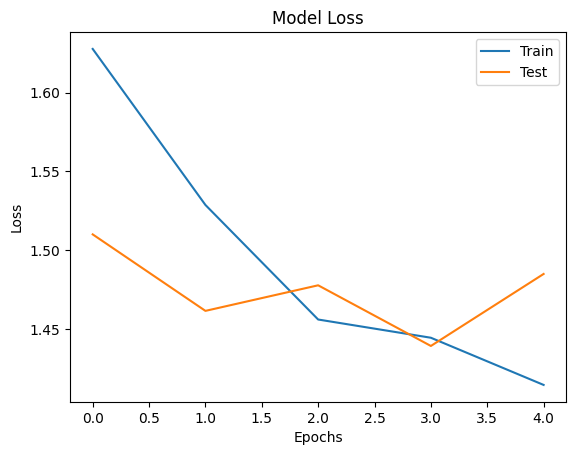

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

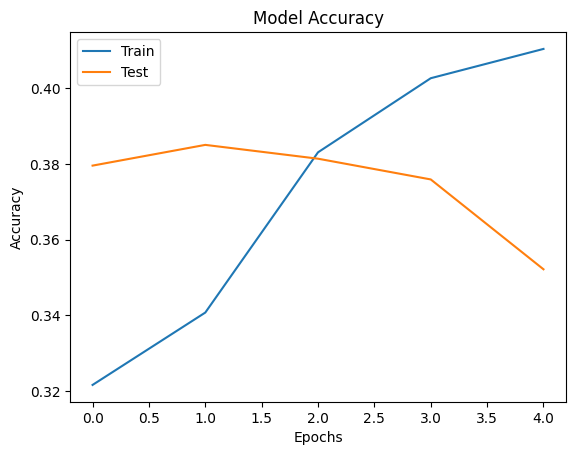

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [31]:
train_loss_rn, train_acc_rn = model.evaluate(train_ds, batch_size=BATCH_SIZE)
test_loss_rn, test_acc_rn = model.evaluate(val_ds, batch_size=BATCH_SIZE)
time_rn = perf_counter() - start_time
print(time_rn)

44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 645ms/step - accuracy: 0.3622 - loss: 1.4962
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.3513 - loss: 1.4874
201.87700917399707


## Transfer Learning: InceptionV3 Pre-trained Model 

In [32]:
start_time = perf_counter()

pre_trained_model = InceptionV3(include_top=False, weights="imagenet", pooling='avg', classifier_activation='softmax')

model = models.Sequential([
    pre_trained_model,
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(len(CLASS_NAMES), activation='softmax')
], name = 'InceptionV3_Model')

model.layers[0].trainable = False

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "InceptionV3_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ ?                      │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [33]:
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 63s 962ms/step - accuracy: 0.5852 - loss: 1.1934 - val_accuracy: 0.7245 - val_loss: 0.6905
Epoch 2/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 515ms/step - accuracy: 0.8512 - loss: 0.4651 - val_accuracy: 0.8102 - val_loss: 0.5358
Epoch 3/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 30s 581ms/step - accuracy: 0.8706 - loss: 0.3654 - val_accuracy: 0.8321 - val_loss: 0.4888
Epoch 4/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 511ms/step - accuracy: 0.8864 - loss: 0.3068 - val_accuracy: 0.8321 - val_loss: 0.4484
Epoch 5/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 513ms/step - accuracy: 0.9000 - loss: 0.2668 - val_accuracy: 0.8522 - val_loss: 0.4014


### Evaluating the InceptionV3 CNN Model Performance

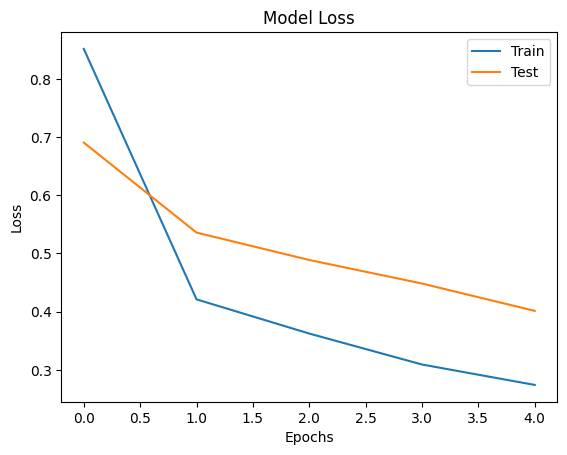

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

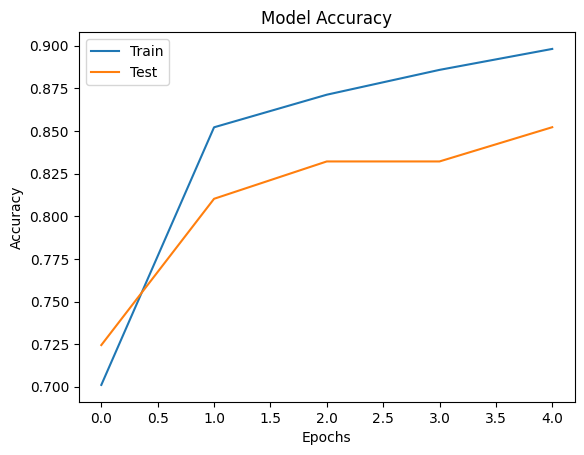

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [36]:
#train_loss_iv, train_acc_iv 
train_loss_iv, train_acc_iv = model.evaluate(train_ds, batch_size=BATCH_SIZE)
test_loss_iv, test_acc_iv = model.evaluate(val_ds, batch_size=BATCH_SIZE)
time_iv = perf_counter() - start_time
print(time_iv)

44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 561ms/step - accuracy: 0.9259 - loss: 0.2404
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.8527 - loss: 0.3924
207.3588307509999


## Sumary  

In [37]:
print("===========================================================================")
print("===============  Compare CNN Algorithms Acurancy and Time =================")
print()
print("   Dataset size = ",SIZE_OF_DATASET,"   Train sample = ",(1-VAL_SAMPLE)*100,"%  Test sample = ",VAL_SAMPLE*100,"%")
print("   Image size: (%d,%d)   Batch size = %d         Epochs = %d        " % (IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, EPOCHS))
print()
print("Processing images:                                          time = %3.1f s" % (time_ip))
print("Simple Model:         train_acc = %1.2f    test_acc = %1.2f   time = %3.1f s" % (train_acc_sm, test_acc_sm, time_sm))
print("Complex Model:        train_acc = %1.2f    test_acc = %1.2f   time = %3.1f s" % (train_acc_cm, test_acc_cm, time_cm))
print("VGG19:                train_acc = %1.2f    test_acc = %1.2f   time = %3.1f s" % (train_acc_vg, test_acc_vg, time_vg))
print("ResNet50:             train_acc = %1.2f    test_acc = %1.2f   time = %3.1f s" % (train_acc_rn, test_acc_rn, time_rn))
print("InceptionV3:          train_acc = %1.2f    test_acc = %1.2f   time = %3.1f s" % (train_acc_iv, test_acc_iv, time_iv))
print("===========================================================================")

===============  Compare CNN Algorithms Acurancy and Time =================

   Dataset size =  2746    Train sample =  80.0 %  Test sample =  20.0 %
   Image size: (224,224)   Batch size = 50         Epochs = 5        

Processing images:                                          time = 0.2 s
Simple Model:         train_acc = 0.35    test_acc = 0.34   time = 169.2 s
Complex Model:        train_acc = 0.47    test_acc = 0.47   time = 205.5 s
VGG19:                train_acc = 0.93    test_acc = 0.85   time = 181.4 s
ResNet50:             train_acc = 0.36    test_acc = 0.35   time = 201.9 s
InceptionV3:          train_acc = 0.92    test_acc = 0.85   time = 207.4 s
